In [1]:
#plan 
# get data
# limo reconstruct
# get com
# move into gate 0
# create sinograms
#    look
#    save
# reconstruct
# look at images

In [2]:
import kex_data

In [3]:
limo_dset, _ = kex_data.listmode()
#limo_dset = [limo[:100*1000] for limo in limo_dset] #sublist for testing
print(len(limo_dset))

4


In [4]:
import listmode

In [5]:
limo_recons = [listmode.get_fov_image_bins(limo) for limo in limo_dset]
print(limo_recons[0].keys())
print(len(limo_recons))

dict_keys(['is_event', 'events', 'tof_lor', 'is_prompt', 'prompts', 'prompt_image_bins', 'is_image_fov', 'fov_image_bins'])
4


In [6]:
import position

In [7]:
coms = [position.listmode_center(recon_dict['fov_image_bins']) for recon_dict in limo_recons]
print(len(coms))
print(coms[0])

4
[ 54.33545783  99.8896029  100.34831253]


In [8]:
import kex_headers
import representation
import numpy as np

In [37]:
toflor_mixtures = {}
keyed_limo_recons = dict(zip(kex_data.DATA_KEYS, limo_recons))
keyed_coms = dict(zip(kex_data.DATA_KEYS, coms))
is_shifted_keep = []
for pkey in kex_data.PHANTOM_KEYS:
    for gkey in kex_data.GATE_KEYS:
        dkey = " ".join([pkey, gkey])
        recon_dict = keyed_limo_recons[dkey]
        if gkey == "0":
            toflor_mixtures[pkey] = recon_dict['tof_lor']
            ref = keyed_coms[dkey]
        else:
            translation = ref - keyed_coms[dkey]
            translation_mm = translation*kex_headers.MM_PER_PIXEL
            print(pkey)
            print("translation_mm", translation_mm)
            moved_toflor, is_fov = representation.move_translation(recon_dict['tof_lor'], translation_mm)
            randoms = recon_dict['is_prompt'] == False
            delays = moved_toflor[0] == 13 #randoms are still randoms
            non_random_delays = randoms != delays
            nrd_sum = np.sum(non_random_delays)
            fov_sum = np.sum(is_fov)
            print("fov count", fov_sum)
            print("ratio ", fov_sum/len(is_fov))
            print("non-random delays count", nrd_sum)
            print("ratio", nrd_sum/len(is_fov))
            keep = non_random_delays == False
            print("not delay excluded count", np.sum(keep))
            keep = np.all([keep, is_fov], axis=0)
            keep_sum = np.sum(keep)
            is_shifted_keep.append(keep)
            print("keep count", keep_sum)
            print("ratio", keep_sum/len(keep))
            toflor_mixtures[pkey] = moved_toflor[:, keep]
            #toflor_mixtures[pkey] = listmode.join_gates((toflor_mixtures[pkey], moved_toflor[:, keep]))

cylinder
translation_mm [ 1.93186657e-02 -3.79719186e+01  2.55296357e-01]
fov count 16587945
ratio  0.985904807211227
non-random delays count 716483
ratio 0.04258417989601011
not delay excluded count 16108615
keep count 15896317
ratio 0.9447978846839407
cannula
translation_mm [ 7.84224656e-03 -6.82439667e+01  5.97562614e-01]
fov count 37161555
ratio  0.9954299462675149
non-random delays count 568144
ratio 0.015218619118392946
not delay excluded count 36764021
keep count 36625970
ratio 0.9810834705139656


In [10]:
shape = kex_headers.HISTOGRAM_SHAPE
mc_sinograms = {key: listmode.get_histogram(toflor, shape, dtype=np.uint16) for key, toflor in toflor_mixtures.items()}

In [11]:
import matplotlib.pyplot as plt

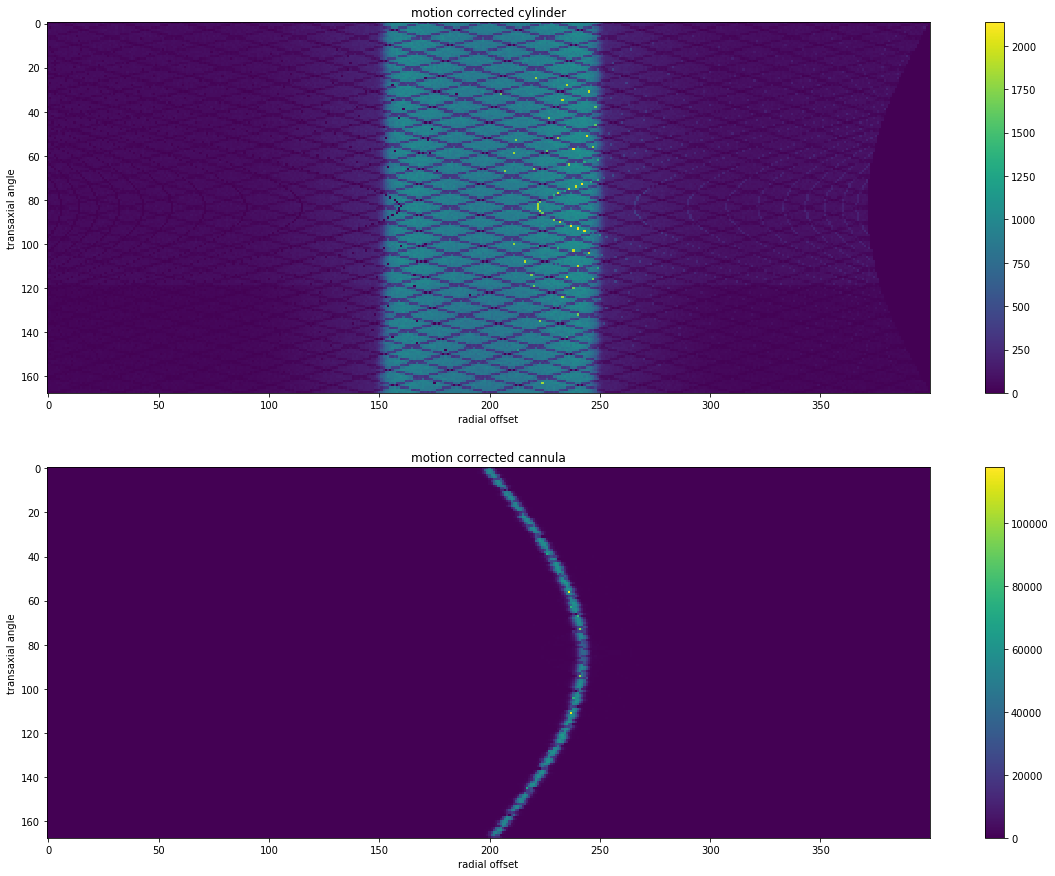

In [17]:
#check before saving and reconstructing
fig, axes = plt.subplots(nrows=2, figsize=(20,15))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    
    #im = ax.imshow(mc_sinograms[pkey][0,50])
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, :109], axis=(0,1)))
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, 600:], axis=(0,1)))
    im = ax.imshow(np.sum(mc_sinograms[pkey], axis=(0,1)))
    ax.set_xlabel("radial offset")
    ax.set_ylabel("transaxial angle")
    ax.set_title("motion corrected " +pkey )
    fig.colorbar(im, ax=ax)

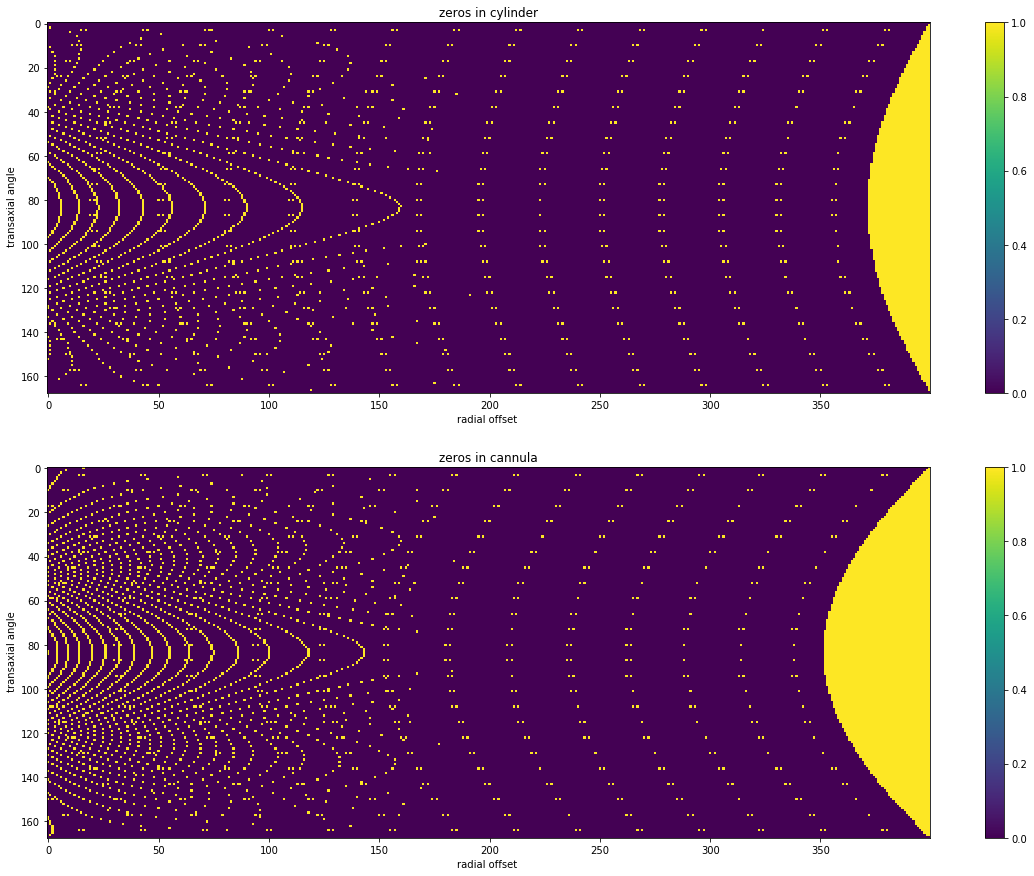

In [18]:
#check before saving and reconstructing
fig, axes = plt.subplots(nrows=2, figsize=(20,15))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    
    #im = ax.imshow(mc_sinograms[pkey][0,50])
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, :109], axis=(0,1)))
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, 600:], axis=(0,1)))
    im = ax.imshow(1*(np.sum(mc_sinograms[pkey], axis=(0,1)) == 0))
    ax.set_xlabel("radial offset ")
    ax.set_ylabel(" transaxial angle")
    ax.set_title("zeros in " +pkey )
    fig.colorbar(im, ax=ax)

In [19]:
ref_sinograms = kex_data.get_sinograms()

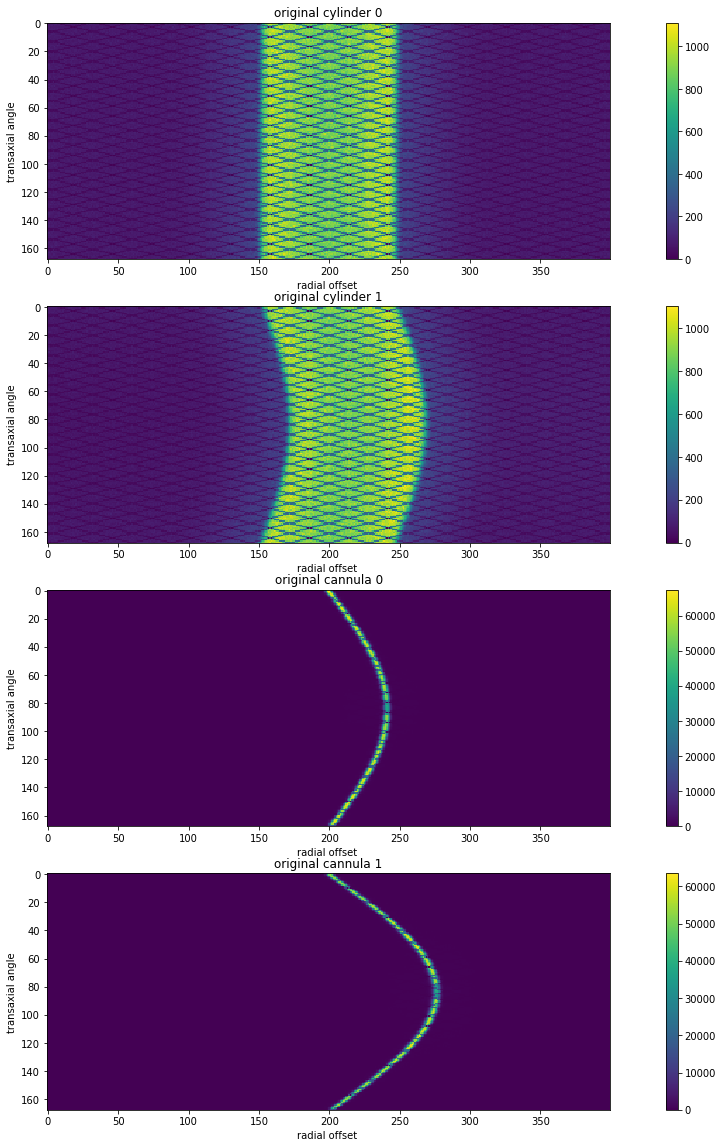

In [20]:
fig, axes = plt.subplots(nrows=4, figsize=(20,20))
for (dkey, sino), ax in zip(ref_sinograms.items(), axes.flatten()):
    im = ax.imshow(np.sum(sino, axis=(0,1)))
    ax.set_xlabel("radial offset ")
    ax.set_ylabel("transaxial angle")
    ax.set_title("original " + dkey)
    fig.colorbar(im, ax=ax)

In [41]:
# now what happens if only data from the left "(ro < 200)" is shifted?
ro_windows = [recon_dict['tof_lor'][-1] < 200 for recon_dict in limo_recons]
ro_windows = ro_windows[1::2] # extract moved gate
is_fov_ro_windows = [ro_window[is_fov] for ro_window, is_fov in zip(ro_windows, is_shifted_keep)]

In [42]:
for (key, mixture), is_fov in zip(toflor_mixtures.items(), is_shifted_keep):
    print(key, mixture.shape, len(is_fov))

cylinder (4, 15896317) 16825098
cannula (4, 36625970) 37332165


In [45]:
for (key, mixture), is_fov in zip(toflor_mixtures.items(), is_shifted_keep):
    print(key, mixture.shape, np.sum((is_fov)))

cylinder (4, 15896317) 15896317
cannula (4, 36625970) 36625970


In [46]:
shape = kex_headers.HISTOGRAM_SHAPE
pairs = zip(toflor_mixtures.items(), is_fov_ro_windows)
ro_mc_limo = {key: toflor[:, ro_windo] for (key, toflor), ro_windo in pairs}
halfro_mc_sinograms = {key: listmode.get_histogram(toflor, shape, dtype=np.uint16) for key, toflor in ro_mc_limo.items()}

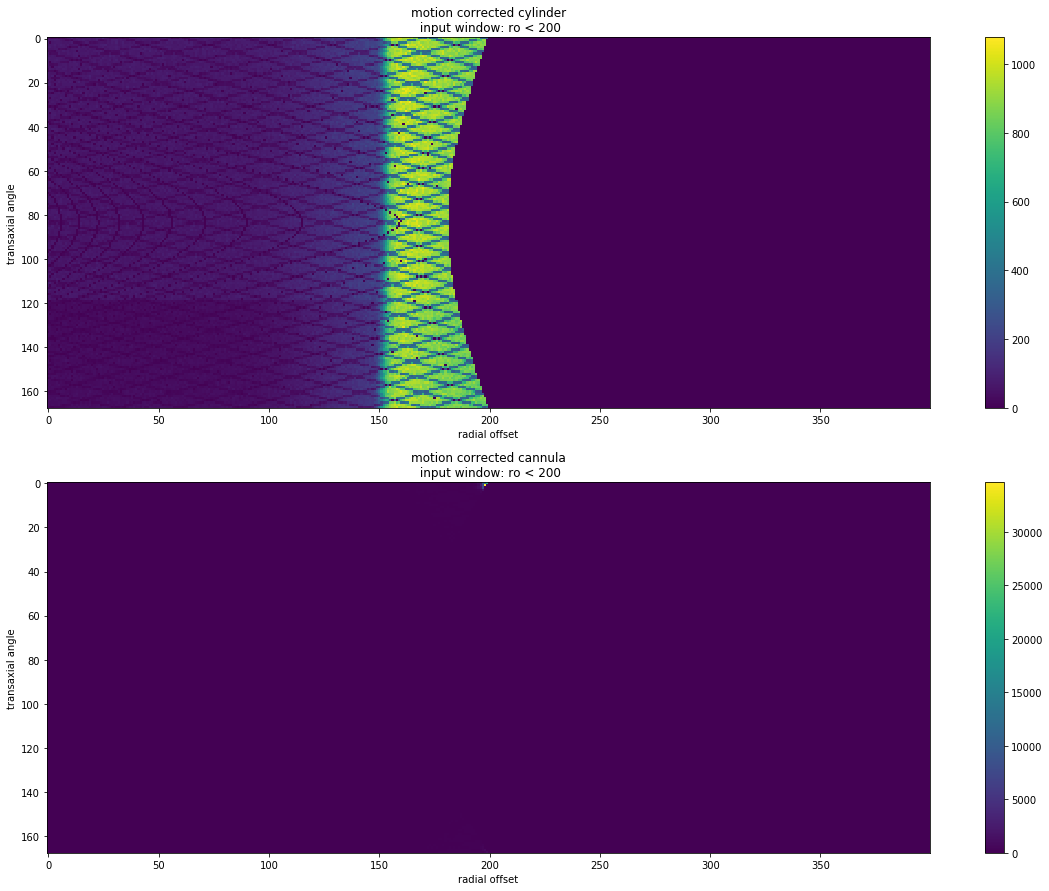

In [50]:
#check before saving and reconstructing
fig, axes = plt.subplots(nrows=2, figsize=(20,15))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    
    #im = ax.imshow(mc_sinograms[pkey][0,50])
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, :109], axis=(0,1)))
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, 600:], axis=(0,1)))
    im = ax.imshow(np.sum(halfro_mc_sinograms[pkey], axis=(0,1)))
    ax.set_xlabel("radial offset")
    ax.set_ylabel("transaxial angle")
    ax.set_title("motion corrected " +pkey + "\n input window: ro < 200")
    fig.colorbar(im, ax=ax)

(0, 110000)

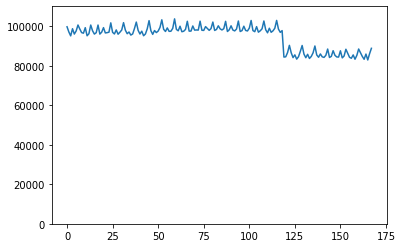

In [54]:
plt.plot(np.arange(168), np.sum(mc_sinograms['cylinder'], axis=(0,1,3)))
plt.ylim(0,110*1000)

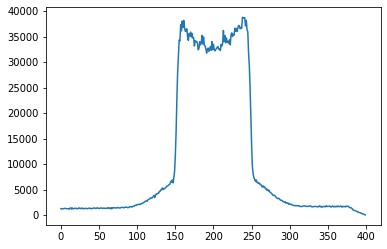

In [56]:
plt.plot(np.arange(400), np.sum(mc_sinograms['cylinder'][:,:,120:], axis=(0,1,2)))

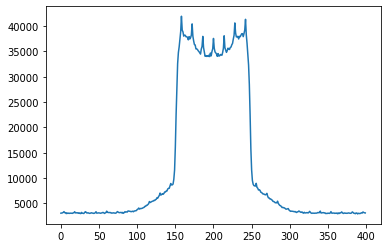

In [58]:
plt.plot(np.arange(400), np.sum(ref_sinograms['cylinder 0'][:,:,120:], axis=(0,1,2)))